In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error
import matplotlib

import ase.io


# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion
from utils.io import write

In [2]:
def rmse2(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [3]:
train_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")
frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

# train_frames = ase.io.read("P_GAP_20_fitting_data.xyz", ":15")
# frames = ase.io.read("P_GAP_20_fitting_data.xyz", ":15")

train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])

test_energy = np.array([
    frame.info["energy"] for frame in frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in frames
])

In [4]:
hypers_lr = {
    'smearing':1,
    'max_angular':6,
    'max_radial':12,
    'cutoff_radius':4.5,
    'potential_exponent':1,
    'radial_basis': 'gto',
    'compute_gradients':True
}

In [5]:
calculator_lr = PyLODESphericalExpansion(hypers_lr)
descriptor_lr = calculator_lr.compute(train_frames)
test_lr = calculator_lr.compute(frames)
inv_lrlr = compute_power_spectrum(descriptor_lr)
inv_test_lr = compute_power_spectrum(test_lr)

In [6]:
inv_lrlr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_lrlr.keys_to_samples('center_species')
inv_test_lr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_lr.keys_to_samples('center_species')

In [7]:
support_lrlr = select_support_points(inv_lrlr, n_select=100)

In [8]:
e_regs = np.geomspace(1e-5,1e0,20)
f_regs = np.geomspace(1e-5,1e0,20)
X, Y = np.meshgrid(e_regs, f_regs)

Z_e = []
Z_f = []
Z_total = []

for f_reg in f_regs:
    e_rmse = []
    f_rmse = []
    total_rmse = []
    for e_reg in e_regs:
        
        model_lrlr = SparseKernelGap(support_points=support_lrlr, zeta=2, regularizer=[e_reg, f_reg])
        
        model_lrlr.fit(inv_lrlr, train_energy, train_forces)

        pred_energy_lrlr, pred_forces_lrlr = model_lrlr.predict(inv_test_lr, with_forces=True)
    
        pred_energy_lrlr = np.concatenate(pred_energy_lrlr)
        
        test_energy_per_atom=[]
        pred_energy_lrlr_per_atom=[]

        for i in np.arange(len(frames)):
            n_atoms = len(frames[i])
            test_energy_per_atom.append(test_energy[i]/n_atoms)
            pred_energy_lrlr_per_atom.append(pred_energy_lrlr[i]/n_atoms)

        test_energy_per_atom=np.array(test_energy_per_atom)
        pred_energy_lrlr_per_atom=np.array(pred_energy_lrlr_per_atom)

        rmse_e_test = rmse2(test_energy_per_atom, pred_energy_lrlr_per_atom)
        rmse_f_test = rmse2(test_forces.flatten(), pred_forces_lrlr.flatten())
        
        e_rmse.append(rmse_e_test)
        f_rmse.append(rmse_f_test)
        total_rmse.append(np.sqrt((rmse_e_test**2 + rmse_f_test**2)/2))
    
    Z_e.append(e_rmse)
    Z_f.append(f_rmse)
    Z_total.append(total_rmse)

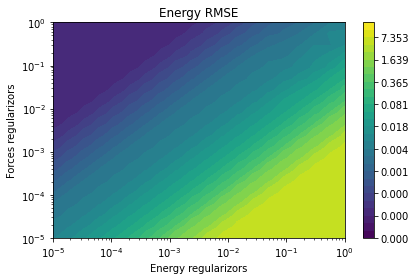

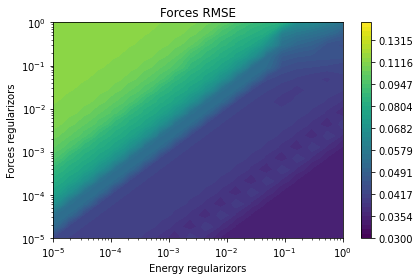

In [29]:
Z_e = np.array(Z_e)
Z_f = np.array(Z_f)
Z_total = np.array(Z_total)

fig, ax = plt.subplots()
levels = np.geomspace(1e-5,20,30)
cb = ax.contourf(X, Y, Z_e,norm=matplotlib.colors.LogNorm(),levels=levels)
fig.colorbar(cb)
ax.set_title('Energy RMSE')
ax.set_xlabel('Energy regularizors')
ax.set_ylabel('Forces regularizors')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()

fig, ax = plt.subplots()
levels = np.geomspace(3e-2,1.5e-1,50)
cb = ax.contourf(X, Y, Z_f,norm=matplotlib.colors.LogNorm(),levels=levels)
fig.colorbar(cb) 
ax.set_title('Forces RMSE')
ax.set_xlabel('Energy regularizors')
ax.set_ylabel('Forces regularizors')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()